In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pickle
import random
import requests
import io
import zipfile
from scipy.stats import norm
from scipy.stats import gaussian_kde


A Multifactor Perspective on Volatility-Managed
Portfolios: Demiguel (2024)<br>
- Factor data: Long-short self-financing: ours is long
- Mkt-RF for market Profy
- Cost differences
- Objective function is inherently non-linar, we flip it around a bit by normalizing after the optimization outcome


In [3]:
industry_mkt = pd.read_csv('industry_mkt.csv')

In [4]:
industry_mkt.head() 

,date,Durbl,Enrgy,HiTec,Hlth,Manuf,NoDur,Other,Shops,Telcm,Utils,Mkt-RF
0,2015-12-14,-0.0028,0.0076,0.0050,0.0040,-0.0016,0.0054,-0.0005,0.0077,0.0003,0.0001,0.0029
1,2015-12-15,0.0097,0.0291,0.0041,0.0173,0.0035,0.0089,0.0193,-0.0006,0.0119,0.0083,0.0110
2,2015-12-16,0.0266,-0.0070,0.0140,0.0152,0.0141,0.0183,0.0159,0.0153,0.0189,0.0230,0.0147
3,2015-12-17,-0.0222,-0.0244,-0.0147,-0.0135,-0.0149,-0.0125,-0.0150,-0.0145,-0.0137,-0.0040,-0.0146
4,2015-12-18,-0.0131,-0.0140,-0.0183,-0.0131,-0.0169,-0.0166,-0.0221,-0.0102,-0.0187,-0.0131,-0.0169


In [5]:
# add the dates!!! Align with the paper
# month zero ( May) will be empty, so officially we have from June
START = pd.Timestamp("2016-05-01") # match it
END   = pd.Timestamp("2022-12-31")

# Methodology: Ex-Post normalization:
## Objective function does not include sum up to 1 constraints
## Optimal output is normalized

Let $r_{d,k}$ be daily simple returns for factor $k=1,\dots,K$. Monthly factor returns are compounded:
$$
R_{t,k}=\prod_{d\in t}(1+r_{d,k})-1,
\qquad
R_t\in\mathbb{R}^K.
$$

Let $\sigma_{t-1}$ be lagged realized volatility of a market proxy (Mkt--RF), estimated from daily returns in month $t-1$.

#### Extended return moments
Define the extended vector
$$
R^{\text{ext}}_t=
\begin{bmatrix}
R_t\\
R_t/\sigma_{t-1}
\end{bmatrix}
\in\mathbb{R}^{2K}.
$$
Estimate
$$
\hat\mu=\frac{1}{T}\sum_{t=1}^T R^{\text{ext}}_t,
\qquad
\hat\Sigma=\mathrm{Cov}(R^{\text{ext}}_t).
$$

#### Timing rule + ex-post normalization
Let $\eta=[a^\top,b^\top]^\top\in\mathbb{R}^{2K}$ with $a,b\in\mathbb{R}^K$. Unnormalized loadings:
$$
\theta_t(a,b)=a+\frac{b}{\sigma_{t-1}}.
$$
Ex-post normalized portfolio weights:
$$
w_t(a,b)=\frac{\theta_t(a,b)}{\mathbf{1}^\top\theta_t(a,b)}.
$$

#### Drift-based turnover and transaction costs
Pre-trade (drifted) weights:
$$
w^{\text{pre}}_t=
\frac{w^{\text{post}}_{t-1}\odot (1+R_{t-1})}
{\mathbf{1}^\top\left(w^{\text{post}}_{t-1}\odot (1+R_{t-1})\right)}.
$$
Turnover:
$$
\tau_t(\eta)=\frac12\sum_{k=1}^K\left|w_{t,k}(\eta)-w^{\text{pre}}_{t,k}(\eta)\right|.
$$
Average cost penalty:
$$
\mathrm{TC}(\eta)=c\cdot \frac{1}{T-1}\sum_{t=2}^T \tau_t(\eta).
$$

#### In-sample estimation and returns
Estimate $\eta$ via
$$
\min_{\eta}\; \frac{\gamma}{2}\eta^\top\hat\Sigma\,\eta-\hat\mu^\top\eta+\mathrm{TC}(\eta).
$$
Implemented returns, where the monthly cost is spreaded evenly over the days:
$$
r^{g}_{p,t}=w_t^\top R_t,
\qquad
r^{n}_{p,t}=r^{g}_{p,t}-c\,\tau_t.
$$

In [7]:

def compute_monthly_factor_returns_from_daily(daily_factors: pd.DataFrame, factor_cols=None):
    '''
    Input: simple daily returns, not log, that is why it is multiplicative. Same set up as before
    '''
    if factor_cols is None:
        factor_cols = list(daily_factors.columns)

    x = daily_factors[factor_cols].copy().dropna(how="all") # no mkt-rf
    month = x.index.to_period("M")

    monthly = (1.0 + x).groupby(month).prod() - 1.0
    monthly.index = monthly.index.to_timestamp("M")
    return monthly.sort_index()
    
# with drift-turnover cost
def Markowitz_with_turnover_TC(
    daily_factors, factor_cols,
    gamma=5.0, ridge=1e-8, nonneg=True,
    normalize_weights=True,
    market_vol_proxy="Mkt-rf",
    c_tc=0.001, abs_eps=1e-10,
    use_drift_turnover=True,              # TRUE = drift turnover (RL,Vol paper style); FALSE = no costs at all
    paper_longshort=False,                 # TRUE = paper-style: allow long-short and NO normalization and NO costs
    bounded_b = False                            ):

    #  paper-style long-short baseline: NO normalization + do not allow negative params + NO costs 
    if paper_longshort:
        '''
        No cost long-short portfolios with a,b>= 0 constraint
        '''
        normalize_weights = False
        nonneg = True
        use_drift_turnover = False  # paper baseline : no transaction costs in objective

    # just to be sure. Mkt-rf is for scaling.
    # No cash: interpretation?
    factor_cols = [c for c in factor_cols if c != market_vol_proxy] # for optimization (input to markowitz), safety

    monthly_F = compute_monthly_factor_returns_from_daily(daily_factors, factor_cols=factor_cols) # monthly returns, do not include MKT-RF
    m = daily_factors.dropna().index.to_period("M")

    # realized volatility on Mkt-rf, we ll use it for scaling
    mkt_col = market_vol_proxy

    rv = daily_factors[mkt_col].groupby(m).std(ddof=1) 
    rv2 = rv.shift(1)  # use lagged volatility (no look-ahead)
    rv2.index = rv2.index.to_timestamp("M")
    rv2 = rv2.reindex(monthly_F.index) # assign the original index to match

    # align and drop months where lagged vol is missing
    valid = rv2.notna()
    Rm = monthly_F.loc[valid]
    s = rv2.loc[valid].to_numpy().reshape(-1, 1)# we need to reshape cause of the division part 

    # Extended returns: [R_t, R_t / sigma_{t-1}]
    R = Rm.to_numpy()  # (T x K)
    K = R.shape[1]
    s = np.maximum(s, 1e-12)  # safety
    R_ext = np.concatenate([R, R / s], axis=1)  # (T x 2K): officially they define the mu and sigma based on this vector
    # 

    # mu_ext and sigma_ext are the sample mean of the extended factor return: so the whole return +
    # scaled return ( r_k/ market_vol) : discuss...
    mu = np.mean(R_ext, axis=0)
    Sigma = np.cov(R_ext, rowvar=False) + ridge * np.eye(2 * K)

    def smooth_abs(x):
        return np.sqrt(x*x + abs_eps)

    def eta_to_theta(eta):
        # Calculate the time varying weights
        a = eta[:K]
        b = eta[K:]

        # Compute the time-varying weights theta_t = a + b / sigma_{t-1}
        theta = a[None, :] + b[None, :] / s  # (T x K), s is already shifted

        if normalize_weights: # paper does differently. It was not constrained.
            denom = np.sum(theta, axis=1, keepdims=True)
            denom = np.where(np.abs(denom) > 1e-12, denom, 1.0)  # safety
            theta = theta / denom

        return theta

    def taus_series(eta):
        # TRUE = drift turnover (RL-style pre-trade drift turnover)
        # FALSE = do not even calculate costs: if we do not calculate costs, we should stuck to long-short also 
        if not use_drift_turnover:
            return np.zeros(R.shape[0], dtype=float)

        theta = eta_to_theta(eta)
        T = theta.shape[0]
        taus = np.zeros(T, dtype=float)
        if T <= 1:
            return taus

        for t in range(1, T):
            # last month target (post-trade)
            w_prev_post = theta[t-1] # already normalized

            # realized monthly returns during last month
            R_prev = R[t-1]

            # drift to pre-trade weights
            g = 1.0 + R_prev
            numer = w_prev_post * g
            denom = float(np.sum(numer))
            w_pre = numer / denom if abs(denom) > 1e-12 else w_prev_post

            # trade to current target
            w_target = theta[t]

            # turnover
            tau_t = 0.5 * float(np.sum(smooth_abs(w_target - w_pre)))
            taus[t] = tau_t # save monthly costs--> use it for net retunrs, we do not multiply with c_tc here!
            # later for cost calculation you need it

        return taus

    def TC(eta):
        # TRUE = drift turnover (RL-style pre-trade drift turnover)
        # FALSE = do not even calculate costs: if we do not calculate costs, we should stuck to long-short also 
        if not use_drift_turnover:
            return 0.0

        taus = taus_series(eta)
        return c_tc * float(np.mean(taus[1:])) if taus.shape[0] > 1 else 0.0 # no drift in the beginning

    def objective(eta):
        # paper-style:
        # max  mu'eta - TC(eta) - (gamma/2) eta'Sigma eta
        # => min (gamma/2) eta'Sigma eta - mu'eta + TC(eta)
        return 0.5 * gamma * float(eta @ Sigma @ eta) - float(mu @ eta) + TC(eta)

    # initial guess
    guess = np.ones(2 * K) / (2 * K)

    constraints = []  # keep empty (no equality constraint): add up to one effect?

    # bounds: if nonneg True => both a,b >= 0; if False, a >= 0 but b unbounded for volatility timing
    if nonneg:
        bounds = [(0.0, None)] * (2 * K)  # Both a and b >= 0
    else:
        bounds = [(0.0, None)] * K + [(None, None)] * K  # a >= 0, b unbounded

    if bounded_b:
        bounds = [(0, None)] * K + [(0, 0)] * K

    result = minimize(
        objective,
        x0=guess,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP',
        options={'maxiter': 100000}
    )

    eta = result.x
    a = eta[:K]
    b = eta[K:]

    theta = eta_to_theta(eta) # normalized weight after optimization
    weights = pd.DataFrame(theta, index=Rm.index, columns=Rm.columns)

    # portfolio return in month t: sum_k w_{k,t} * R_{k,t}
    port_ret_gross = (weights * Rm).sum(axis=1) 

    # Substract the costs (month-by-month, consistent with drift turnover)
    taus = taus_series(eta) # just drift turnover witohut c_tc 
    costs = c_tc * taus # monthly
    port_ret_net = port_ret_gross - pd.Series(costs, index=Rm.index) # monthly!

    return {
        "a": pd.Series(a, index=Rm.columns, name="a"),
        "b": pd.Series(b, index=Rm.columns, name="b"),
        "weights": weights,
        "portfolio_returns_gross": port_ret_gross,
        "portfolio_returns_net": port_ret_net,
        "turnover": pd.Series(taus, index=Rm.index, name="turnover"),
        "costs": pd.Series(costs, index=Rm.index, name="costs"),
        "opt_result": result,
        "TC_in_sample": TC(eta),
        "use_drift_turnover": use_drift_turnover,
        "paper_longshort": paper_longshort
    }


In [8]:
# we need daily and not monthly returns
def daily_portfolio_returns_from_monthly_weights(daily_returns: pd.DataFrame,
                                                 W_monthly: pd.DataFrame) -> pd.Series:
    """
    W_monthly is indexed by month-end, but represents weights USED during that month
    (because it was built using lagged vol already). At the end of the month we observed the previous month volatility! so we
    can assign the same month as for returns we dont need to use any lags here!
    """
    R = daily_returns.dropna(how="any").copy()
    month = R.index.to_period("M")

    W = W_monthly.copy()
    W["m"] = W.index.to_period("M")
    W = W.set_index("m").sort_index()

    out = []
    months = sorted(month.unique())
    for m_trade in months:
        if m_trade not in W.index:
            continue

        w = W.loc[m_trade]
        cols = [c for c in w.index if c in R.columns]
        Rt = R.loc[month == m_trade, cols]
        if Rt.empty:
            continue

        out.append(pd.Series(Rt.values @ w[cols].values, index=Rt.index))

    return pd.concat(out).sort_index()


def portfolio_stats_paper_style(returns,
                                periods_per_year=252,
                                rf_annual=0.0,
                                target=0.0,
                                alpha=0.95):

    r = pd.Series(returns).dropna().astype(float).to_numpy()
    if len(r) < 2:
        raise ValueError("need at least 2 observations")
    if not (0.0 < alpha < 1.0):
        raise ValueError("alpha must be in (0,1)")

    mu = float(np.mean(r))
    sigma2 = float(np.var(r, ddof=0))
    sigma = float(np.sqrt(sigma2))

    mu_ann = mu * periods_per_year
    sigma2_ann = sigma2 * periods_per_year
    sigma_ann = float(np.sqrt(sigma2_ann))

    # downside RMS / LPM2
    downside = (r[r < target] - target)
    semivar = 0.0 if downside.size == 0 else float(np.mean(downside**2))
    semidev_ann = float(np.sqrt(semivar * periods_per_year))

    # VaR/CVaR
    q = 1.0 - alpha
    VaR = float(np.quantile(r, q))
    tail = r[r <= VaR]
    CVaR = VaR if tail.size == 0 else float(np.mean(tail))

    # drawdowns
    wealth = np.concatenate([[1.0], np.cumprod(1.0 + r)])
    peak = np.maximum.accumulate(wealth)
    dd = 1.0 - wealth / peak
    pos_dd = dd[dd > 0]
    avg_dd = 0.0 if pos_dd.size == 0 else float(np.mean(pos_dd))

    # excess mean (per-period rf from annual rf)
    rf_per = (1.0 + rf_annual)**(1.0 / periods_per_year) - 1.0
    excess_ann_mean = (mu - rf_per) * periods_per_year

    sharpe = np.nan if sigma_ann == 0 else float(excess_ann_mean / sigma_ann)
    sortino = np.nan if semidev_ann == 0 else float(excess_ann_mean / semidev_ann)

    # tail-adjusted Sharpe (NO annualization of CVaR/mVaR)
    ta_sharpe_cvar = np.nan if CVaR == 0 else float(excess_ann_mean / abs(CVaR))

    # Cornish-Fisher modified VaR
    if sigma == 0:
        skew = 0.0
        exkurt = 0.0
    else:
        xc = r - mu
        m3 = float(np.mean(xc**3))
        m4 = float(np.mean(xc**4))
        skew = m3 / (sigma**3)
        kurt = m4 / (sigma**4)
        exkurt = kurt - 3.0

    z = float(norm.ppf(q))
    z_cf = (z
            + (1/6)  * (z**2 - 1)   * skew
            + (1/24) * (z**3 - 3*z) * exkurt
            - (1/36) * (2*z**3 - 5*z) * (skew**2))

    mVaR = float(mu + sigma * z_cf)
    ta_sharpe_mvar = np.nan if mVaR == 0 else float(excess_ann_mean / abs(mVaR))

    return {
        "Ann. Mean (%)": 100 * mu_ann,
        "Ann. StdDev (%)": 100 * sigma_ann,
        "Ann. SemiDev (%)": 100 * semidev_ann,
        "CVaR 95% (%)": 100 * CVaR,
        "Avg DD (%)": 100 * avg_dd,
        "VaR 95% (%)": 100 * VaR,
        "Sharpe (ann.)": sharpe,
        "Sortino (ann.)": sortino,
        "Tail-Adj Sharpe (CVaR95)": ta_sharpe_cvar,
        "Tail-Adj Sharpe (mVaR95)": ta_sharpe_mvar,
    }


def make_table_for_portfolios(portfolios: dict,
                              periods_per_year=252,
                              rf_annual=0.0,
                              target=0.0,
                              alpha=0.95) -> pd.DataFrame:
    rows = [
        "Ann. Mean (%)",
        "Ann. StdDev (%)",
        "Ann. SemiDev (%)",
        "CVaR 95% (%)",
        "Avg DD (%)",
        "VaR 95% (%)",
        "Sharpe (ann.)",
        "Sortino (ann.)",
        "Tail-Adj Sharpe (CVaR95)",
        "Tail-Adj Sharpe (mVaR95)",
    ]

    out = pd.DataFrame(index=rows)
    for name, r in portfolios.items():
        st = portfolio_stats_paper_style(r, periods_per_year=periods_per_year,
                                         rf_annual=rf_annual, target=target, alpha=alpha)
        out[name] = [st[k] for k in rows]
    return out

def df_to_booktabs_latex(df: pd.DataFrame, caption=None, label=None) -> str:
    latex = df.to_latex(
        escape=True,
        float_format=lambda x: f"{x:.2f}",
        column_format="l" + "r"*df.shape[1],
        bold_rows=False
    )
    # convert to booktabs style
    latex = latex.replace("\\toprule", "\\toprule").replace("\\midrule", "\\midrule").replace("\\bottomrule", "\\bottomrule")
    if caption or label:
        # wrap in table environment if requested
        body = latex
        lines = ["\\begin{table}[!htbp]", "\\centering"]
        if caption:
            lines.append(f"\\caption{{{caption}}}")
        if label:
            lines.append(f"\\label{{{label}}}")
        lines.append(body.strip())
        lines.append("\\end{table}")
        latex = "\n".join(lines)
    return latex

In [9]:
df = pd.read_csv("industry_mkt.csv")

# Date index
date_col = next((c for c in ["date", "Date", "DATE"] if c in df.columns), None)
if date_col is None:
    raise ValueError("No date column found (expected date/Date/DATE).")
df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col).sort_index()

# Market proxy column
market_vol_proxy = "Mkt-RF"
factor_cols = list(df.columns)  # includes market proxy; Markowitz removes it internally


# Impose cost 0.015: 
- check the correlation with the linear output
- check the sign of the scaling factor correlation with the returns
- plot and interpret the tails

# Robustness:
- Plot the weights
- check scaling factor correlation with returns. If positive, we do derisking
- check correlation of the weighted returns with the linear and normalized
- plot

# Same exercise with cost 0.015

In [13]:
#################
# c= 0.025--> in case of 100% turnover, it is 2.5%
#################
res_tc_c015 = Markowitz_with_turnover_TC(
    df,
    factor_cols=list(df.columns),
    nonneg=False, # if False : else [(0.0, None)] * K + [(None, None)] * K, so b is unbounded
    normalize_weights=True,
    use_drift_turnover=True,# dirft based cost: similar to ours just without bid-ask
    c_tc=0.015,
    bounded_b=False,
    paper_longshort=False,
    market_vol_proxy=market_vol_proxy # Mkrt-RF
)


In [14]:
res_tc_c015.keys()

dict_keys(['a', 'b', 'weights', 'portfolio_returns_gross', 'portfolio_returns_net', 'turnover', 'costs', 'opt_result', 'TC_in_sample', 'use_drift_turnover', 'paper_longshort'])

In [15]:
res_tc_c015['TC_in_sample']

0.0012138477972345675

In [16]:
res_tc_c015['a'],res_tc_c015['b']

(Durbl    3.834132e-18
 Enrgy    1.054584e-01
 HiTec    1.963712e-17
 Hlth     0.000000e+00
 Manuf    2.949937e-19
 NoDur    0.000000e+00
 Other    3.257010e-17
 Shops    3.869229e-18
 Telcm    2.300485e-18
 Utils    0.000000e+00
 Name: a, dtype: float64,
 Durbl   -0.000527
 Enrgy   -0.001406
 HiTec    0.010202
 Hlth     0.000325
 Manuf   -0.009749
 NoDur   -0.003373
 Other    0.008930
 Shops    0.000271
 Telcm    0.000002
 Utils    0.007289
 Name: b, dtype: float64)

In [17]:
res_tc_c015["weights"].sum(axis=1)

date
2016-01-31    1.0
2016-02-29    1.0
2016-03-31    1.0
2016-04-30    1.0
2016-05-31    1.0
             ... 
2024-04-30    1.0
2024-05-31    1.0
2024-06-30    1.0
2024-07-31    1.0
2024-08-31    1.0
Freq: ME, Length: 104, dtype: float64

In [18]:
W_monthly_res_tc_c015 = res_tc_c015["weights"]
#######################################
# add the dates!!! Align with the paper
#######################################

W_monthly_res_tc_c015 = W_monthly_res_tc_c015.loc[(W_monthly_res_tc_c015.index >= START) & (W_monthly_res_tc_c015.index <= END)].copy()


# DAILY portfolio returns: to match the tables
asset_cols = [c for c in df.columns if c != market_vol_proxy] # we dont need mkt rf
# calculate the returns daily by using the end of month weight and assign it for the whole month
# the weights are already normalized, ahd df[asset_cols] are just the industry factor returns
port_ret_daily_res_tc_c015 = daily_portfolio_returns_from_monthly_weights(df[asset_cols], W_monthly_res_tc_c015)

# spread monthly drift-turnover TC uniformly across trading days within each month (daily net series)
costs_m = res_tc_c015["costs"].loc[W_monthly_res_tc_c015.index]
month = port_ret_daily_res_tc_c015.index.to_period("M")
for dt_m, c in costs_m.items():
    m = dt_m.to_period("M")
    idx = port_ret_daily_res_tc_c015.index[month == m]
    n = len(idx)
    if n > 0:
        port_ret_daily_res_tc_c015.loc[idx] -= float(c) / n

port_ret_daily_res_tc_c015.name = "VolTimed_Markowitz"

ports = {"VolTimed_Markowitz": port_ret_daily_res_tc_c015}
tbl = make_table_for_portfolios(ports, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)
print(tbl.round(3))


                          VolTimed_Markowitz
Ann. Mean (%)                         18.219
Ann. StdDev (%)                       22.997
Ann. SemiDev (%)                      24.303
CVaR 95% (%)                          -3.330
Avg DD (%)                             5.968
VaR 95% (%)                           -2.119
Sharpe (ann.)                          0.792
Sortino (ann.)                         0.750
Tail-Adj Sharpe (CVaR95)               5.472
Tail-Adj Sharpe (mVaR95)               9.197


In [19]:
ports_df = pd.concat(ports, axis=1)         
ports_df.index.name = "Date"
ports_df = ports_df.sort_index()

ports_df = ports_df.dropna(how="any")

ports_df.to_csv("cost015.csv")

In [20]:

cost015 = pd.read_csv("cost015.csv")
datecol = cost015.columns[0]
cost015[datecol] = pd.to_datetime(cost015[datecol])

# build portfolios dict
portfolios = {c: cost015[c].dropna().astype(float).values for c in cost015.columns if c != datecol}

# build table
tab = make_table_for_portfolios(portfolios, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)

# output latex
latex_str = df_to_booktabs_latex(tab, caption=None, label=None)
with open("portfolio_stats_transposed.tex", "w") as f:
    f.write(latex_str)

print(latex_str)

\begin{tabular}{lr}
\toprule
 & VolTimed\_Markowitz \\
\midrule
Ann. Mean (\%) & 18.22 \\
Ann. StdDev (\%) & 23.00 \\
Ann. SemiDev (\%) & 24.30 \\
CVaR 95\% (\%) & -3.33 \\
Avg DD (\%) & 5.97 \\
VaR 95\% (\%) & -2.12 \\
Sharpe (ann.) & 0.79 \\
Sortino (ann.) & 0.75 \\
Tail-Adj Sharpe (CVaR95) & 5.47 \\
Tail-Adj Sharpe (mVaR95) & 9.20 \\
\bottomrule
\end{tabular}



C:\Users\95att\AppData\Local\Temp\ipykernel_42888\2165444212.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  W_q_res_tc_c015 = W_res_tc_c015.resample("Q").mean()


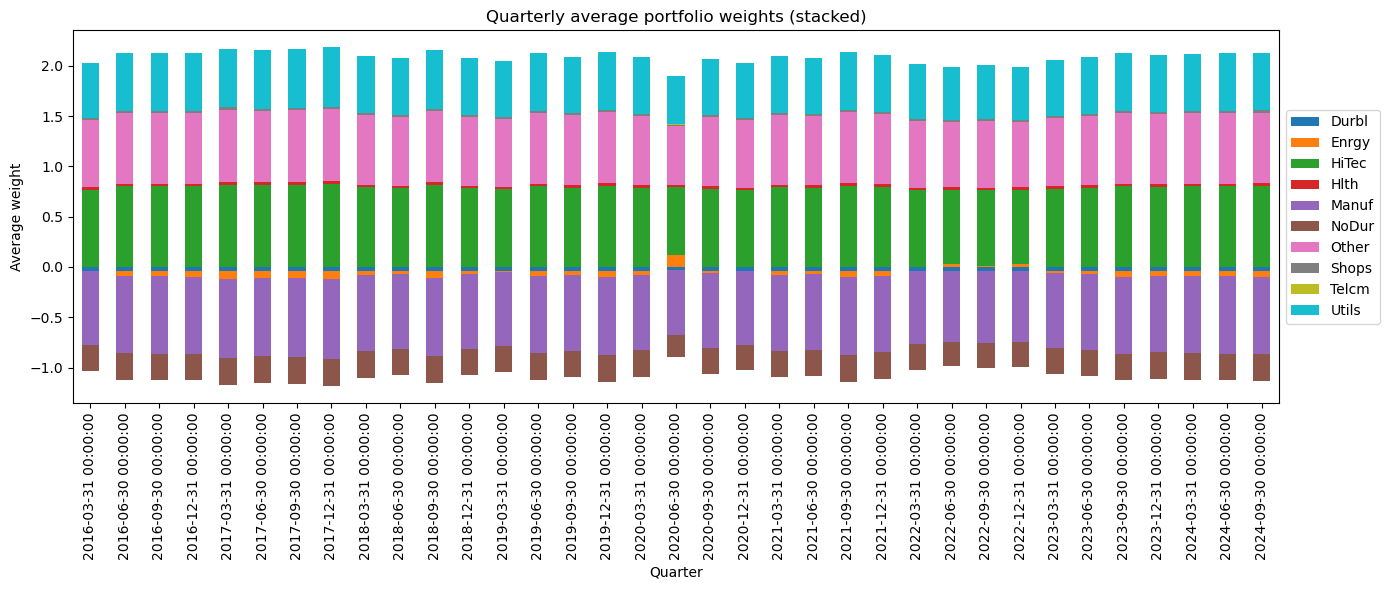

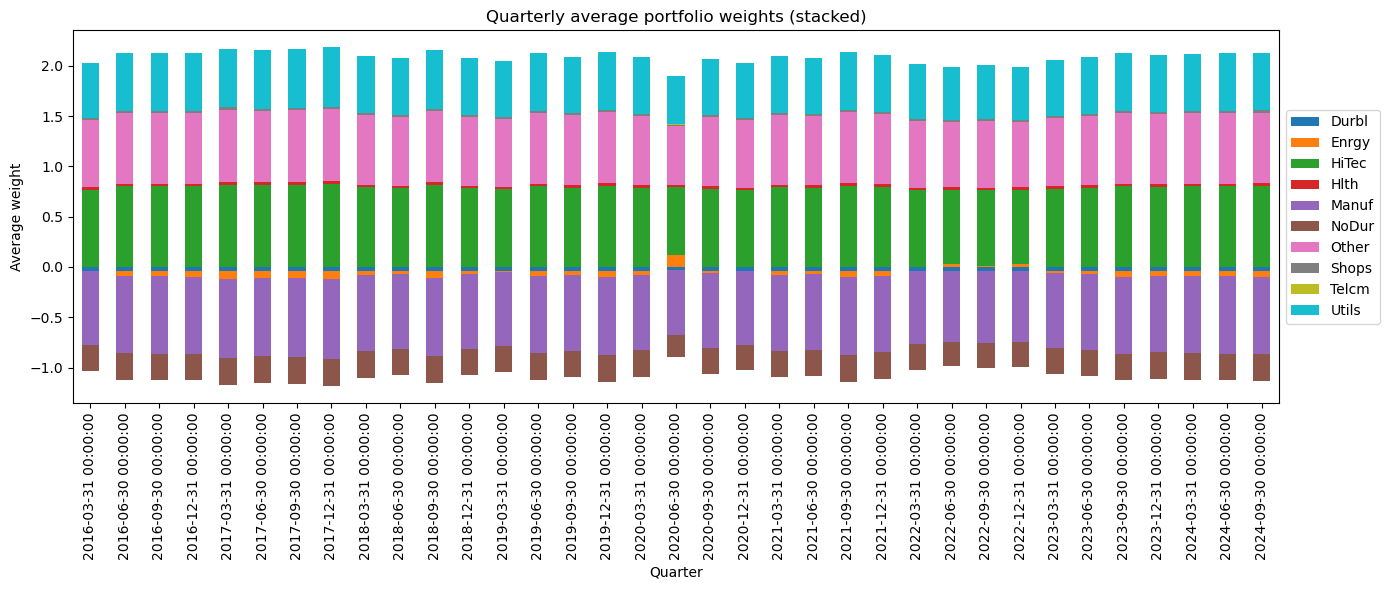

In [21]:

# res is the dict returned by Markowitz(...)
W_res_tc_c015 = res_tc_c015["weights"].copy()  # monthly weights (index = month-end)

# quarterly average weights
W_q_res_tc_c015 = W_res_tc_c015.resample("Q").mean()

plt.figure(figsize=(14, 6))
W_q_res_tc_c015.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Quarterly average portfolio weights (stacked)")
plt.xlabel("Quarter")
plt.ylabel("Average weight")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Unconditional case b=0
- Calculating costs as before
- Normalize weights too
- short is not allowed, which means a>=0 

In [23]:
# Use the original function defined above
res_tc_c015_uncod=true = Markowitz_with_turnover_TC(
    df,
    factor_cols=list(df.columns),
    paper_longshort=False,
    nonneg=False,
    c_tc=0.015,
    market_vol_proxy=market_vol_proxy,
    bounded_b = True,
    normalize_weights = True,
    use_drift_turnover=True
)



In [24]:
res_tc_c015_uncod['a']

Durbl    5.042872e-17
Enrgy    3.363583e-17
HiTec    9.480540e-01
Hlth     0.000000e+00
Manuf    6.362056e-17
NoDur    0.000000e+00
Other    2.671603e-17
Shops    2.949030e-17
Telcm    2.237098e-19
Utils    4.347870e-01
Name: a, dtype: float64

In [25]:
res_tc_c015_uncod['b']


Durbl    0.0
Enrgy    0.0
HiTec    0.0
Hlth     0.0
Manuf    0.0
NoDur    0.0
Other    0.0
Shops    0.0
Telcm    0.0
Utils    0.0
Name: b, dtype: float64

In [26]:
res_tc_c015_uncod['weights'].sum(axis=1)

date
2016-01-31    1.0
2016-02-29    1.0
2016-03-31    1.0
2016-04-30    1.0
2016-05-31    1.0
             ... 
2024-04-30    1.0
2024-05-31    1.0
2024-06-30    1.0
2024-07-31    1.0
2024-08-31    1.0
Freq: ME, Length: 104, dtype: float64

In [27]:
W_monthly_res_tc_c015_uncod = res_tc_c015_uncod["weights"]

W_monthly_res_tc_c015_uncod = W_monthly_res_tc_c015_uncod.loc[(W_monthly_res_tc_c015_uncod.index >= START) & (W_monthly_res_tc_c015_uncod.index <= END)].copy()


# DAILY portfolio returns: to match the tables
asset_cols = [c for c in df.columns if c != market_vol_proxy] # we dont need mkt rf
# calculate the returns daily by using the end of month weight and assign it for the whole month
# the weights are already normalized, ahd df[asset_cols] are just the industry factor returns
port_ret_daily_res_tc_c015_uncod = daily_portfolio_returns_from_monthly_weights(df[asset_cols], W_monthly_res_tc_c015_uncod)

# spread monthly drift-turnover TC uniformly across trading days within each month (daily net series)
costs_m = res_tc_c015_uncod["costs"].loc[W_monthly_res_tc_c015_uncod.index]
month = port_ret_daily_res_tc_c015_uncod.index.to_period("M")
for dt_m, c in costs_m.items():
    m = dt_m.to_period("M")
    idx = port_ret_daily_res_tc_c015_uncod.index[month == m]
    n = len(idx)
    if n > 0:
        port_ret_daily_res_tc_c015_uncod.loc[idx] -= float(c) / n

port_ret_daily_res_tc_c015_uncod.name = "VolTimed_Markowitz"

ports = {"VolTimed_Markowitz_Uncod": port_ret_daily_res_tc_c015_uncod}
tbl = make_table_for_portfolios(ports, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)
print(tbl.round(3))

                          VolTimed_Markowitz_Uncod
Ann. Mean (%)                               16.366
Ann. StdDev (%)                             20.817
Ann. SemiDev (%)                            22.438
CVaR 95% (%)                                -3.151
Avg DD (%)                                   5.486
VaR 95% (%)                                 -2.010
Sharpe (ann.)                                0.786
Sortino (ann.)                               0.729
Tail-Adj Sharpe (CVaR95)                     5.194
Tail-Adj Sharpe (mVaR95)                     8.826


In [28]:
res_tc_c015_uncod['TC_in_sample']

0.00013916846879986108

In [29]:
# Do everything with cost = 0.03

res_tc_c03_uncod = Markowitz_with_turnover_TC(
    df,
    factor_cols=list(df.columns),
    paper_longshort=False,
    c_tc=0.03,
    market_vol_proxy=market_vol_proxy,
    bounded_b = True,
    normalize_weights = True,
    nonneg=False,
    use_drift_turnover=True
)



#######################################
# add the dates!!! Align with the paper
#######################################

W_monthly_res_tc_c03_uncod = res_tc_c03_uncod["weights"]

W_monthly_res_tc_c03_uncod = W_monthly_res_tc_c03_uncod.loc[(W_monthly_res_tc_c03_uncod.index >= START) & (W_monthly_res_tc_c03_uncod.index <= END)].copy()


# DAILY portfolio returns: to match the tables
asset_cols = [c for c in df.columns if c != market_vol_proxy] # we dont need mkt rf
# calculate the returns daily by using the end of month weight and assign it for the whole month
# the weights are already normalized, ahd df[asset_cols] are just the industry factor returns
port_ret_daily_res_tc_c03_uncod = daily_portfolio_returns_from_monthly_weights(df[asset_cols], W_monthly_res_tc_c03_uncod)

# spread monthly drift-turnover TC uniformly across trading days within each month (daily net series)
costs_m = res_tc_c03_uncod["costs"].loc[W_monthly_res_tc_c03_uncod.index]
month = port_ret_daily_res_tc_c03_uncod.index.to_period("M")
for dt_m, c in costs_m.items():
    m = dt_m.to_period("M")
    idx = port_ret_daily_res_tc_c03_uncod.index[month == m]
    n = len(idx)
    if n > 0:
        port_ret_daily_res_tc_c03_uncod.loc[idx] -= float(c) / n

port_ret_daily_res_tc_c03_uncod.name = "VolTimed_Markowitz"

ports = {"VolTimed_Markowitz_Uncod": port_ret_daily_res_tc_c03_uncod}
tbl = make_table_for_portfolios(ports, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)
print(tbl.round(3))


                          VolTimed_Markowitz_Uncod
Ann. Mean (%)                               16.309
Ann. StdDev (%)                             20.919
Ann. SemiDev (%)                            22.497
CVaR 95% (%)                                -3.169
Avg DD (%)                                   5.566
VaR 95% (%)                                 -2.021
Sharpe (ann.)                                0.780
Sortino (ann.)                               0.725
Tail-Adj Sharpe (CVaR95)                     5.147
Tail-Adj Sharpe (mVaR95)                     8.719


### Conclusion: The normalization changes drastically the output. 
#### To be consistent with out RL paper ( weights add up to one and turnover based costs) we need:
- 1) to add into the objective function the normalization
  2) Add sum up to 1 constraints and interpret
  3) Introduce cash

# Different objective
## So far the objective function was based on linear set up
### What we do know is we add a new objective, where the weights are adding up to 1
### We keep everything else as it is
1) **Monthly returns + lagged market volatility**

Same as before
2) **Parametric volatility-timing rule (normalized weights)**

Let $\eta=[a^\top,b^\top]^\top\in\mathbb{R}^{2K}$ with $a,b\in\mathbb{R}^K$. Define unnormalized loadings:
$$
\theta_t(a,b)=a+\frac{b}{\sigma_{t-1}}.
$$
Convert to implementable (fully-invested) portfolio weights:
$$
w_t(a,b)=\frac{\theta_t(a,b)}{\mathbf{1}^\top \theta_t(a,b)}.
$$


3) **Direct in-sample objective (optimize the implemented strategy)**

Monthly portfolio returns implied by $\eta$:
$$
r_{p,t}(\eta)=w_t(\eta)^\top R_t.
$$
Solve:
$$
\min_{\eta}\;\; \frac{\gamma}{2}\,\mathrm{Var}\!\left(r_{p,t}(\eta)\right)\;-\;\mathbb{E}\!\left[r_{p,t}(\eta)\right]\;+\;\mathrm{TC}(\eta).
$$

4) **Benchmarks / constraints**

- **Timing portfolio:** $a\ge 0$, $b$ free (allows volatility-conditioned tilts).  
- **Unconditional benchmark:** set $b=0$ and impose $\sum_k a_k=1$ (fully invested).



In [32]:
# with turnover cost
def Markowitz_with_turnover_TC_diffobj(
    daily_factors, factor_cols,
    gamma=5.0, ridge=1e-8, nonneg=False,
    market_vol_proxy="Mkt-rf",
    c_tc=0.001, abs_eps=1e-10,
    use_drift_turnover=True,              # TRUE = drift turnover (RL,Vol paper style); FALSE = no costs at all
    bounded_b: bool = False           
):

    #  paper-style long-short baseline: NO normalization + allow negative params + NO costs 
    # they said it is 

    # just to be sure. Mkt-rf is for scaling. Again it is a proxy for market vol. What do they use exactly?
    # weight normalization: they dont impose, only for alpha and beta
    # No cash: interpretation?
    factor_cols = [c for c in factor_cols if c != market_vol_proxy] # for optimization (input to markowitz), safety

    monthly_F = compute_monthly_factor_returns_from_daily(daily_factors, factor_cols=factor_cols) # monthly returns, do not include MKT-RF
    m = daily_factors.dropna().index.to_period("M")

    # realized volatility on Mkt-rf, we ll use it for scaling
    mkt_col = market_vol_proxy

    rv = daily_factors[mkt_col].groupby(m).std(ddof=1) 
    rv2 = rv.shift(1)  # use lagged volatility (no look-ahead)
    rv2.index = rv2.index.to_timestamp("M")
    rv2 = rv2.reindex(monthly_F.index) # assign the original index to match

    # align and drop months where lagged vol is missing
    valid = rv2.notna()
    Rm = monthly_F.loc[valid]
    s = rv2.loc[valid].to_numpy().reshape(-1, 1)# we need to reshape cause of the division part 

    # Extended returns: [R_t, R_t / sigma_{t-1}]
    R = Rm.to_numpy()  # (T x K)
    K = R.shape[1]
    T = R.shape[0]
    s = np.maximum(s, 1e-12)  # safety
    ### we use these above R,s inside the objective function and
    def smooth_abs(x):
        return np.sqrt(x*x + abs_eps)

    def eta_to_theta(eta):
        a = eta[:K]
        b = eta[K:]
        theta = a[None, :] + b[None, :] / s
        # Normalize to sum to 1
        denom = np.sum(theta, axis=1, keepdims=True)
        theta = theta / np.where(np.abs(denom) > 1e-12, denom, 1.0)
        return theta

    def taus_series(eta):
        # TRUE = drift turnover (RL-style pre-trade drift turnover)
        # FALSE = do not even calculate costs: if we do not calculate costs, we should stuck to long-short also 
        if not use_drift_turnover:
            return np.zeros(R.shape[0], dtype=float)

        theta = eta_to_theta(eta)
        T = theta.shape[0]
        taus = np.zeros(T, dtype=float)
        if T <= 1:
            return taus

        for t in range(1, T):
            # last month target (post-trade)
            w_prev_post = theta[t-1]

            # realized monthly returns during last month
            R_prev = R[t-1]

            # drift to pre-trade weights
            g = 1.0 + R_prev
            numer = w_prev_post * g
            denom = float(np.sum(numer))
            w_pre = numer / denom if abs(denom) > 1e-12 else w_prev_post

            # trade to current target
            w_target = theta[t]

            # turnover
            tau_t = 0.5 * float(np.sum(smooth_abs(w_target - w_pre)))
            taus[t] = tau_t # save monthly costs--> use it for net retunrs, we do not multiply with c_tc here!
            # later for cost calculation you need

        return taus

    def TC(eta):
        # TRUE = drift turnover (RL-style pre-trade drift turnover)
        # FALSE = do not even calculate costs: if we do not calculate costs, we should stuck to long-short also 
        if not use_drift_turnover:
            return 0.0

        taus = taus_series(eta)
        return c_tc * float(np.mean(taus[1:])) if taus.shape[0] > 1 else 0.0 # no drift in the beginning

    def objective(eta):
        theta = eta_to_theta(eta)
        rp = np.sum(theta * R, axis=1)      # monthly portfolio return series, no R_ext!!!
        mu_p = float(rp.mean())
        var_p = float(rp.var(ddof=0))
        return 0.5 * gamma * var_p - mu_p + TC(eta)

    # initial guess
    guess = np.ones(2 * K) / (2 * K)

    constraints = []  # keep empty (no equality constraint): add up to one effect?

    # If unconditional benchmark (no timing): force b = 0 AND enforce sum(a)=1 (fully invested)
    # Fully invested constraint is needed for valid cost calculation (drift assumes normalized weights)
    if bounded_b:
        constraints.append({"type": "eq", "fun": lambda eta: np.sum(eta[:K]) - 1.0})  # sum(a) = 1

    # bounds: if nonneg True => both a,b >= 0; if False, a >= 0 but b unbounded for volatility timing
    if nonneg:
        bounds = [(0.0, None)] * (2 * K)  # Both a and b >= 0
    else:
        bounds = [(0.0, None)] * K + [(None, None)] * K  # a >= 0, b unbounded

    # If unconditional benchmark (bounded_b=True): force b = 0
    if bounded_b:
        bounds = [(0, None)] * K + [(0, 0)] * K  # Force all b values to exactly 0
    result = minimize(
        objective,
        x0=guess,
        bounds=bounds,
        constraints=constraints,
        method='SLSQP',
        options={'maxiter': 100000}
    )

    eta = result.x
    a = eta[:K]
    b = eta[K:]

    theta = eta_to_theta(eta)
    weights = pd.DataFrame(theta, index=Rm.index, columns=Rm.columns)

    # portfolio return in month t: sum_k w_{k,t} * R_{k,t}
    port_ret_gross = (weights * Rm).sum(axis=1)

    # Substract the costs (month-by-month, consistent with drift turnover)
    taus = taus_series(eta) # just 
    costs = c_tc * taus # monthly
    port_ret_net = port_ret_gross - pd.Series(costs, index=Rm.index)

    return {
        "a": pd.Series(a, index=Rm.columns, name="a"),
        "b": pd.Series(b, index=Rm.columns, name="b"),
        "weights": weights,
        "portfolio_returns": port_ret_gross,
        "portfolio_returns_gross": port_ret_gross,
        "portfolio_returns_net": port_ret_net,
        "turnover": pd.Series(taus, index=Rm.index, name="turnover"),
        "costs": pd.Series(costs, index=Rm.index, name="costs"),
        "opt_result": result,
        "TC_in_sample": TC(eta),
        "use_drift_turnover": use_drift_turnover,
        "bounded_b": bounded_b
    }


In [33]:
res_tc_c03_diffobj = Markowitz_with_turnover_TC_diffobj(
    df,
    factor_cols=list(df.columns),
    c_tc=0.03,
    nonneg= False,
    market_vol_proxy=market_vol_proxy,
    bounded_b = False,
    use_drift_turnover=True  
)



In [34]:
W_monthly_res_tc_c03_diffobj = res_tc_c03_diffobj["weights"]
#######################################
# add the dates!!! Align with the paper
#######################################
START = pd.Timestamp("2016-05-01") # match it
END   = pd.Timestamp("2022-12-31")
W_monthly_res_tc_c03_diffobj = W_monthly_res_tc_c03_diffobj.loc[(W_monthly_res_tc_c03_diffobj.index >= START) & (W_monthly_res_tc_c03_diffobj.index <= END)].copy()


# DAILY portfolio returns: to match the tables
asset_cols = [c for c in df.columns if c != market_vol_proxy] # we dont need mkt rf
# calculate the returns daily by using the end of month weight and assign it for the whole month
# the weights are already normalized, ahd df[asset_cols] are just the industry factor returns
port_ret_daily_res_tc_c03_diffobj = daily_portfolio_returns_from_monthly_weights(df[asset_cols], W_monthly_res_tc_c03_diffobj)

# spread monthly drift-turnover TC uniformly across trading days within each month (daily net series)
costs_m = res_tc_c03_diffobj["costs"].loc[W_monthly_res_tc_c03_diffobj.index]
month = port_ret_daily_res_tc_c03_diffobj.index.to_period("M")
for dt_m, c in costs_m.items():
    m = dt_m.to_period("M")
    idx = port_ret_daily_res_tc_c03_diffobj.index[month == m]
    n = len(idx)
    if n > 0:
        port_ret_daily_res_tc_c03_diffobj.loc[idx] -= float(c) / n

port_ret_daily_res_tc_c03_diffobj.name = "VolTimed_Markowitz"

ports = {"VolTimed_Markowitz_003": port_ret_daily_res_tc_c03_diffobj}
tbl = make_table_for_portfolios(ports, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)
print(tbl.round(3))


                          VolTimed_Markowitz_003
Ann. Mean (%)                             24.107
Ann. StdDev (%)                           28.017
Ann. SemiDev (%)                          29.341
CVaR 95% (%)                              -4.137
Avg DD (%)                                 7.322
VaR 95% (%)                               -2.866
Sharpe (ann.)                              0.860
Sortino (ann.)                             0.822
Tail-Adj Sharpe (CVaR95)                   5.827
Tail-Adj Sharpe (mVaR95)                   9.337


In [35]:
res_tc_c03_diffobj['a']

Durbl    6.441928e-03
Enrgy    4.170741e-02
HiTec    2.415589e-02
Hlth     2.743079e-03
Manuf    0.000000e+00
NoDur    3.426276e-03
Other    2.481921e-03
Shops    5.466200e-04
Telcm    7.687967e-19
Utils    3.446263e-02
Name: a, dtype: float64

In [36]:
res_tc_c03_diffobj['b']

Durbl   -0.057712
Enrgy    0.057845
HiTec    0.632134
Hlth     0.000256
Manuf   -0.002244
NoDur   -0.107919
Other    0.001237
Shops   -0.006587
Telcm   -0.262792
Utils    0.222202
Name: b, dtype: float64

In [37]:
res_tc_c03_diffobj['TC_in_sample']

0.001526408199994135

In [38]:
res_tc_c03_diffobj['weights'].sum(axis=1)

date
2016-01-31    1.0
2016-02-29    1.0
2016-03-31    1.0
2016-04-30    1.0
2016-05-31    1.0
             ... 
2024-04-30    1.0
2024-05-31    1.0
2024-06-30    1.0
2024-07-31    1.0
2024-08-31    1.0
Freq: ME, Length: 104, dtype: float64

# Unconditional different object. b=0

In [40]:
res_tc_c03_diffobj_uncond = Markowitz_with_turnover_TC_diffobj(
    df,
    factor_cols=list(df.columns),
    c_tc=0.03,
    nonneg= False,
    market_vol_proxy=market_vol_proxy,
    bounded_b = True,
    use_drift_turnover=True  
)



In [41]:
W_monthly_res_tc_c03_diffobj_uncond = res_tc_c03_diffobj_uncond["weights"]
#######################################
# add the dates!!! Align with the paper
#######################################
START = pd.Timestamp("2016-05-01") # match it
END   = pd.Timestamp("2022-12-31")
W_monthly_res_tc_c03_diffobj_uncond = W_monthly_res_tc_c03_diffobj_uncond.loc[(W_monthly_res_tc_c03_diffobj_uncond.index >= START) & (W_monthly_res_tc_c03_diffobj_uncond.index <= END)].copy()


# DAILY portfolio returns: to match the tables
asset_cols = [c for c in df.columns if c != market_vol_proxy] # we dont need mkt rf
# calculate the returns daily by using the end of month weight and assign it for the whole month
# the weights are already normalized, ahd df[asset_cols] are just the industry factor returns
port_ret_daily_res_tc_c03_diffobj_uncond = daily_portfolio_returns_from_monthly_weights(df[asset_cols], W_monthly_res_tc_c03_diffobj_uncond)

# spread monthly drift-turnover TC uniformly across trading days within each month (daily net series)
costs_m = res_tc_c03_diffobj_uncond["costs"].loc[W_monthly_res_tc_c03_diffobj_uncond.index]
month = port_ret_daily_res_tc_c03_diffobj_uncond.index.to_period("M")
for dt_m, c in costs_m.items():
    m = dt_m.to_period("M")
    idx = port_ret_daily_res_tc_c03_diffobj_uncond.index[month == m]
    n = len(idx)
    if n > 0:
        port_ret_daily_res_tc_c03_diffobj_uncond.loc[idx] -= float(c) / n

port_ret_daily_res_tc_c03_diffobj_uncond.name = "VolTimed_Markowitz"

ports = {"VolTimed_Markowitz_Uncond": port_ret_daily_res_tc_c03_diffobj_uncond}
tbl = make_table_for_portfolios(ports, periods_per_year=252, rf_annual=0.0, target=0.0, alpha=0.95)
print(tbl.round(3))

                          VolTimed_Markowitz_Uncond
Ann. Mean (%)                                18.939
Ann. StdDev (%)                              24.112
Ann. SemiDev (%)                             26.040
CVaR 95% (%)                                 -3.684
Avg DD (%)                                    7.308
VaR 95% (%)                                  -2.425
Sharpe (ann.)                                 0.785
Sortino (ann.)                                0.727
Tail-Adj Sharpe (CVaR95)                      5.140
Tail-Adj Sharpe (mVaR95)                      8.211


In [42]:
res_tc_c03_diffobj_uncond['a']

Durbl    0.000000e+00
Enrgy    0.000000e+00
HiTec    9.670187e-01
Hlth     2.081668e-17
Manuf    0.000000e+00
NoDur    0.000000e+00
Other    0.000000e+00
Shops    3.122502e-17
Telcm    0.000000e+00
Utils    3.298132e-02
Name: a, dtype: float64

In [43]:
res_tc_c03_diffobj_uncond['b']

Durbl    0.0
Enrgy    0.0
HiTec    0.0
Hlth     0.0
Manuf    0.0
NoDur    0.0
Other    0.0
Shops    0.0
Telcm    0.0
Utils    0.0
Name: b, dtype: float64

In [44]:
res_tc_c03_diffobj_uncond['TC_in_sample']

4.207978269959632e-05

In [45]:
res_tc_c03_diffobj_uncond['weights'].sum(axis=1)

date
2016-01-31    1.0
2016-02-29    1.0
2016-03-31    1.0
2016-04-30    1.0
2016-05-31    1.0
             ... 
2024-04-30    1.0
2024-05-31    1.0
2024-06-30    1.0
2024-07-31    1.0
2024-08-31    1.0
Freq: ME, Length: 104, dtype: float64

In [61]:
import numpy as np

# --- toy example dimensions ---
T = 6   # months
K = 3   # factors

# toy monthly factor returns (T x K)
R = np.random.randn(T, K) * 0.02

# toy lagged vol series s_{t-1} (T x 1)
s = np.abs(np.random.randn(T, 1)) + 0.5  # ensure positive

gamma = 5.0

def eta_to_theta(eta, s):
    """
    eta: (2K,) = [a_1..a_K, b_1..b_K]
    returns theta: (T, K)
    """
    a = eta[:K]          # (K,)
    b = eta[K:]          # (K,)
    theta = a[None, :] + b[None, :] / s   # (T,K) + (T,K) via broadcasting
    # normalize each row to sum to 1 (optional, matches your diffobj)
    denom = theta.sum(axis=1, keepdims=True)  # (T,1)
    theta = theta / np.where(np.abs(denom) > 1e-12, denom, 1.0)
    return theta

# example eta
eta = np.array([0.4, 0.3, 0.3,   # a (K,)
                0.1, -0.2, 0.05]) # b (K,)

theta = eta_to_theta(eta, s)

# portfolio return series: rp_t = sum_k theta_{t,k} * R_{t,k}
rp = np.sum(theta * R, axis=1)  # (T,)

mu_p = float(rp.mean())
var_p = float(rp.var(ddof=0))

# --- shape checks ---
print("R shape:", R.shape)            # (T,K)
print("s shape:", s.shape)            # (T,1)
print("eta shape:", eta.shape)        # (2K,)
print("theta shape:", theta.shape)    # (T,K)
print("rp shape:", rp.shape)          # (T,)

print("mu_p:", mu_p)
print("var_p:", var_p)

# sanity check: row sums of theta (should be 1 if normalized)
print("theta row sums:", theta.sum(axis=1))


R shape: (6, 3)
s shape: (6, 1)
eta shape: (6,)
theta shape: (6, 3)
rp shape: (6,)
mu_p: 0.0035345457159050354
var_p: 0.00010693883202455449
theta row sums: [1. 1. 1. 1. 1. 1.]
